# Omdena Capstone Project

## Climate Change Impact Assessment and Prediction System for Nepal
Developing an end-to-end data analysis system that monitors, analyzes, and predicts climate change impacts in Nepal with a focus on vulnerable regions

## 1. Dependencies and DataSet Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style='whitegrid')
plt.style.use('fivethirtyeight')

# Display all columns
pd.set_option('display.max_columns', None)

In [2]:
# Load the climate data
df = pd.read_csv('data/nepal_climate_data.csv')

# Display basic information
print(f'Dataset shape: {df.shape}')
print(f'Original column names: {df.columns.tolist()}')

# Standardize column names to uppercase for consistency
df.columns = [col.strip().upper() for col in df.columns]

# Create a mapping of common column name variations for future reference
column_map = {
    'YEAR': ['YEAR', 'YR', 'YEAR_'],
    'MONTH': ['MO', 'MONTH', 'MON'],
    'DAY': ['DY', 'DAY', 'DATE_DAY'],
    'TEMPERATURE': ['T2M', 'TEMP', 'TEMPERATURE'],
    'MAX_TEMPERATURE': ['T2M_MAX', 'TMAX', 'MAX_TEMP'],
    'MIN_TEMPERATURE': ['T2M_MIN', 'TMIN', 'MIN_TEMP'],
    'PRECIPITATION': ['PRECTOTCORR', 'PRECIP', 'PRECIPITATION'],
    'LATITUDE': ['LATITUDE', 'LAT'],
    'LONGITUDE': ['LONGITUDE', 'LON', 'LNG']
}

# Print standardized column names
print(f'Standardized column names: {df.columns.tolist()}')

# Check for missing values
print(f'\nMissing values: {df.isnull().sum().sum()}')

# Display summary statistics for numeric columns
print('\nBasic statistics:')
print(df.describe().round(2).T)  # Transposed for better readability

# Display sample data
print('\nSample data:')
df.head()

Dataset shape: (394470, 9)
Original column names: [' YEAR', 'MO', 'DY', 'T2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'latitude', 'longitude']
Standardized column names: ['YEAR', 'MO', 'DY', 'T2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'LATITUDE', 'LONGITUDE']

Missing values: 0

Basic statistics:
                count     mean    std      min      25%      50%      75%  \
YEAR         394470.0  2011.50   6.92  2000.00  2005.00  2011.50  2017.00   
MO           394470.0     6.52   3.45     1.00     4.00     7.00    10.00   
DY           394470.0    15.73   8.80     1.00     8.00    16.00    23.00   
T2M          394470.0    13.64  14.44   -29.36     2.80    16.19    26.07   
T2M_MAX      394470.0    20.23  13.92   -20.55     9.67    22.99    31.26   
T2M_MIN      394470.0     8.12  14.87   -40.35    -3.35    10.51    20.93   
PRECTOTCORR  394470.0     2.55   6.95     0.00     0.00     0.03     1.80   
LATITUDE     394470.0    28.00   1.41    26.00    27.00    28.00    29.00   
LONGITUDE  

,YEAR,MO,DY,T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,LATITUDE,LONGITUDE
0,2000,1,1,15.36,25.61,7.14,0.0,26,80
1,2000,1,2,15.99,25.08,7.91,0.0,26,80
2,2000,1,3,16.16,24.95,6.35,0.0,26,80
3,2000,1,4,16.16,25.49,6.06,0.0,26,80
4,2000,1,5,16.19,25.24,8.54,0.0,26,80


## 2. Data Preprocessing

In [3]:
# First, check the actual column names
print("Column names in the dataset:")
print(df.columns.tolist())

# Create date column using the correct column names
# We'll try to find the year, month, and day columns by looking for common patterns
year_col = next((col for col in df.columns if col.lower() in ['year', 'yr']), None)
month_col = next((col for col in df.columns if col.lower() in ['mo', 'month']), None)
day_col = next((col for col in df.columns if col.lower() in ['dy', 'day']), None)

print(f"\nUsing columns: {year_col} (year), {month_col} (month), {day_col} (day)")

# Create date column if all necessary columns were found
if all([year_col, month_col, day_col]):
    df['date'] = pd.to_datetime({
        'year': df[year_col],
        'month': df[month_col], 
        'day': df[day_col]
    })
    print("Date column created successfully")
else:
    print("Could not create date column - missing required columns")

# Create season column if month column was found
if month_col:
    # Create season column
    def get_season(month):
        if month in [12, 1, 2]:  # Winter
            return 'Winter'
        elif month in [3, 4, 5]:  # Spring
            return 'Spring'
        elif month in [6, 7, 8]:  # Summer/Monsoon
            return 'Summer'
        else:  # Fall
            return 'Fall'
            
    df['season'] = df[month_col].apply(get_season)
    print("Season column created successfully")
else:
    print("Could not create season column - missing month column")

# Create temperature range column if max and min temperature columns exist
temp_max_col = next((col for col in df.columns if 'max' in col.lower()), None)
temp_min_col = next((col for col in df.columns if 'min' in col.lower()), None)

if temp_max_col and temp_min_col:
    df['temp_range'] = df[temp_max_col] - df[temp_min_col]
    print("Temperature range column created successfully")
else:
    print("Could not create temperature range column - missing required columns")

# Check the processed data
df.head()

Column names in the dataset:
['YEAR', 'MO', 'DY', 'T2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'LATITUDE', 'LONGITUDE']

Using columns: YEAR (year), MO (month), DY (day)
Date column created successfully
Season column created successfully
Temperature range column created successfully


,YEAR,MO,DY,T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,LATITUDE,LONGITUDE,date,season,temp_range
0,2000,1,1,15.36,25.61,7.14,0.0,26,80,2000-01-01,Winter,18.47
1,2000,1,2,15.99,25.08,7.91,0.0,26,80,2000-01-02,Winter,17.17
2,2000,1,3,16.16,24.95,6.35,0.0,26,80,2000-01-03,Winter,18.60
3,2000,1,4,16.16,25.49,6.06,0.0,26,80,2000-01-04,Winter,19.43
4,2000,1,5,16.19,25.24,8.54,0.0,26,80,2000-01-05,Winter,16.70


## 3. Exploratory Data Analysis

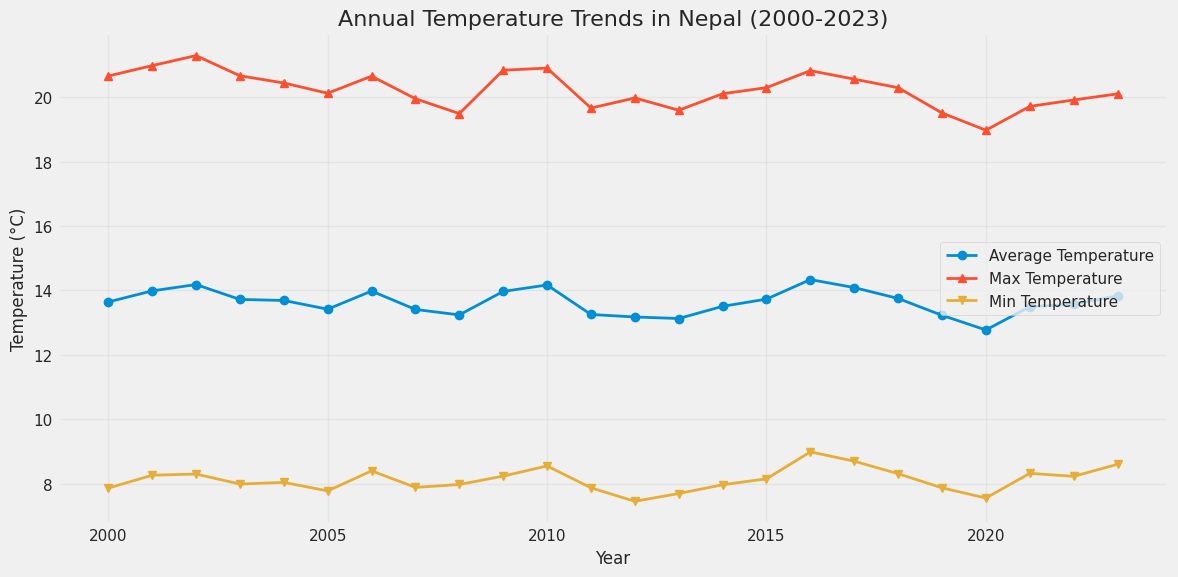

In [5]:
# Annual temperature trends
try:
    # Use the standardized uppercase column names
    yearly_temp = df.groupby('YEAR')[['T2M', 'T2M_MAX', 'T2M_MIN']].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(yearly_temp['YEAR'], yearly_temp['T2M'], marker='o', linewidth=2, label='Average Temperature')
    plt.plot(yearly_temp['YEAR'], yearly_temp['T2M_MAX'], marker='^', linewidth=2, label='Max Temperature')
    plt.plot(yearly_temp['YEAR'], yearly_temp['T2M_MIN'], marker='v', linewidth=2, label='Min Temperature')
    plt.title('Annual Temperature Trends in Nepal (2000-2023)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
except KeyError as e:
    print(f"Error: {e}")
    print("Available columns:", df.columns.tolist())
    
    # Try to find alternative column names if needed
    year_col = next((col for col in df.columns if 'YEAR' in col), None)
    temp_col = next((col for col in df.columns if col in ['T2M', 'TEMP']), None)
    max_col = next((col for col in df.columns if 'MAX' in col), None)
    min_col = next((col for col in df.columns if 'MIN' in col), None)
    
    if all([year_col, temp_col, max_col, min_col]):
        print(f"Using alternative columns: {year_col}, {temp_col}, {max_col}, {min_col}")
        
        yearly_temp = df.groupby(year_col)[[temp_col, max_col, min_col]].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        plt.plot(yearly_temp[year_col], yearly_temp[temp_col], marker='o', linewidth=2, label='Average Temperature')
        plt.plot(yearly_temp[year_col], yearly_temp[max_col], marker='^', linewidth=2, label='Max Temperature')
        plt.plot(yearly_temp[year_col], yearly_temp[min_col], marker='v', linewidth=2, label='Min Temperature')
        plt.title('Annual Temperature Trends in Nepal (2000-2023)', fontsize=16)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Temperature (°C)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Could not find appropriate column names for temperature trend analysis")

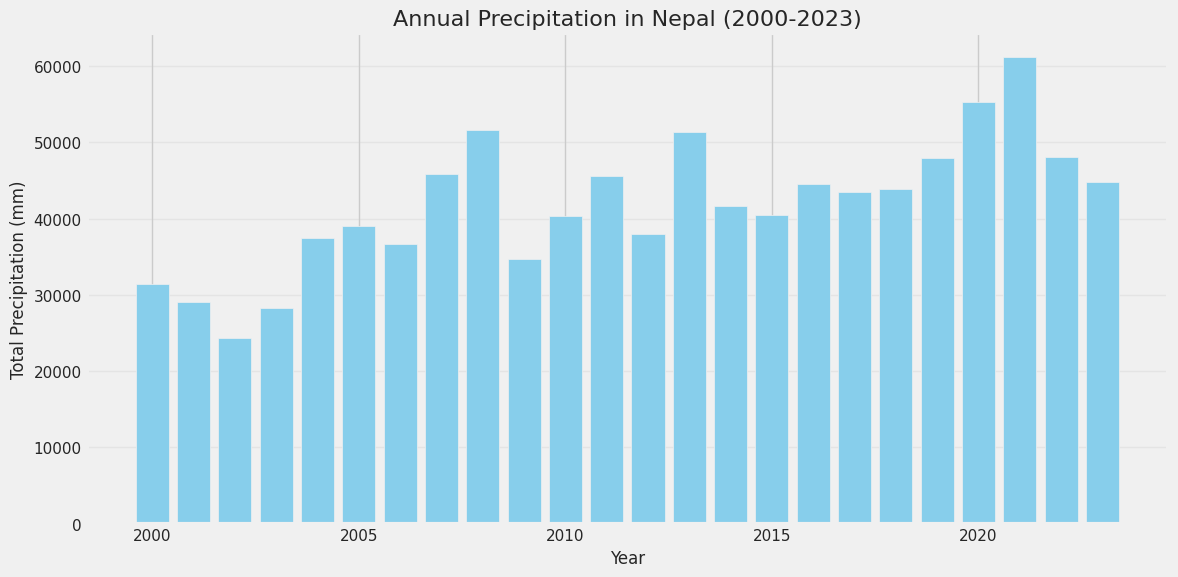

In [6]:
# Precipitation trends
yearly_precip = df.groupby('YEAR')['PRECTOTCORR'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(yearly_precip['YEAR'], yearly_precip['PRECTOTCORR'], color='skyblue')
plt.title('Annual Precipitation in Nepal (2000-2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Precipitation (mm)', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

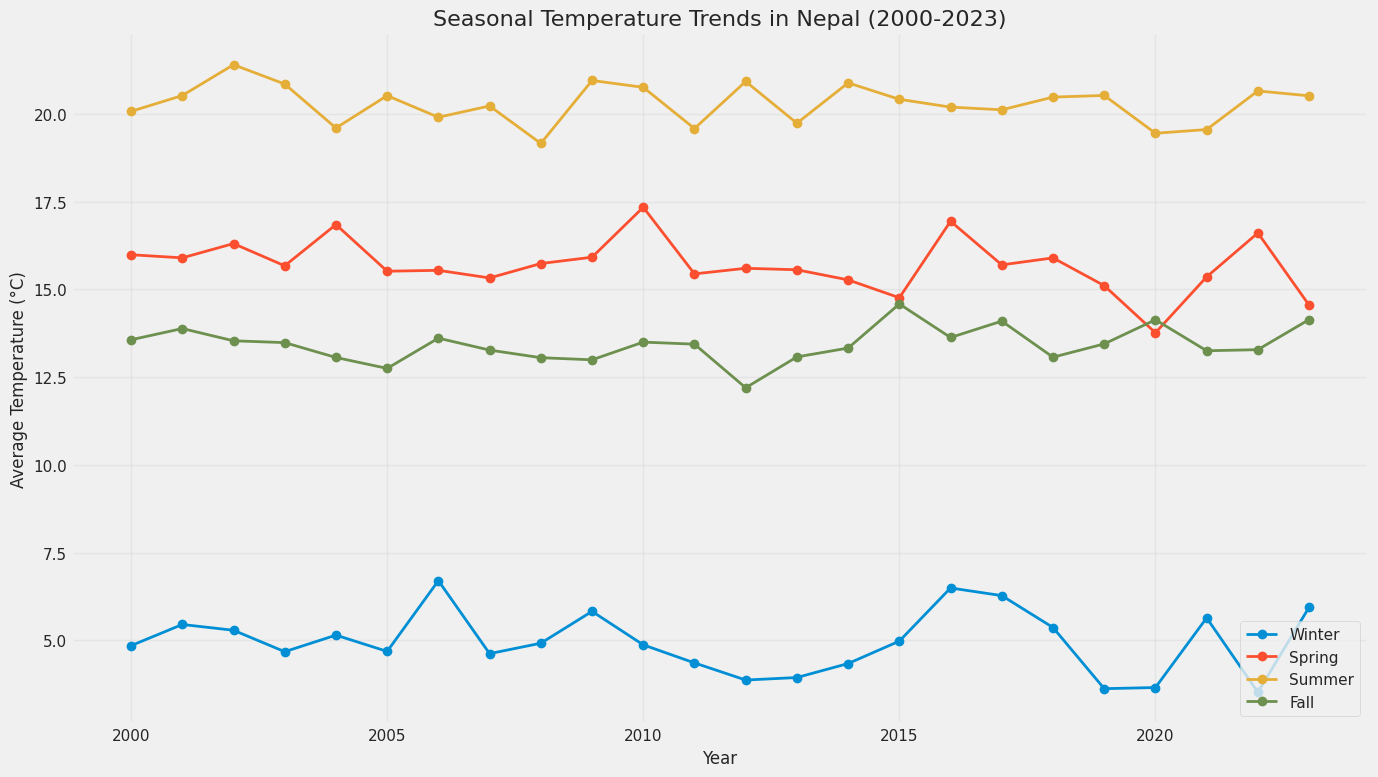

In [7]:
# Seasonal analysis
seasonal_temp = df.groupby(['YEAR', 'season'])[['T2M', 'PRECTOTCORR']].mean().reset_index()

plt.figure(figsize=(14, 8))
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    season_data = seasonal_temp[seasonal_temp['season'] == season]
    plt.plot(season_data['YEAR'], season_data['T2M'], marker='o', linewidth=2, label=season)

plt.title('Seasonal Temperature Trends in Nepal (2000-2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Temperature (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

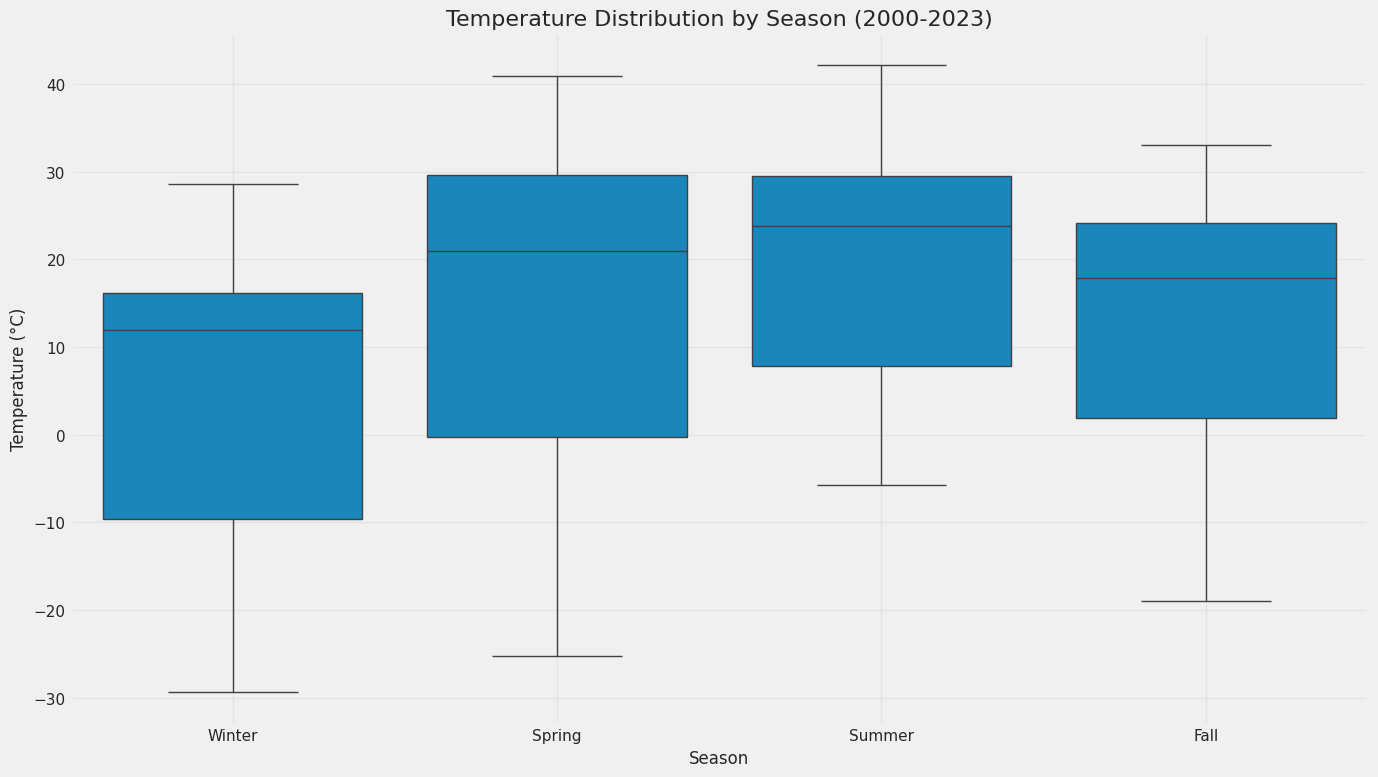

In [8]:
# Temperature distribution by season
plt.figure(figsize=(14, 8))
sns.boxplot(x='season', y='T2M', data=df)
plt.title('Temperature Distribution by Season (2000-2023)', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Extreme Heat Threshold: > 40.76°C (95th percentile)
Extreme Cold Threshold: < -18.62°C (5th percentile)
Heavy Rain Threshold: > 13.46 mm (95th percentile)
Total Extreme Heat Days (2000-2023): 19719
Total Extreme Cold Days (2000-2023): 19724
Total Heavy Rain Days (2000-2023): 19705


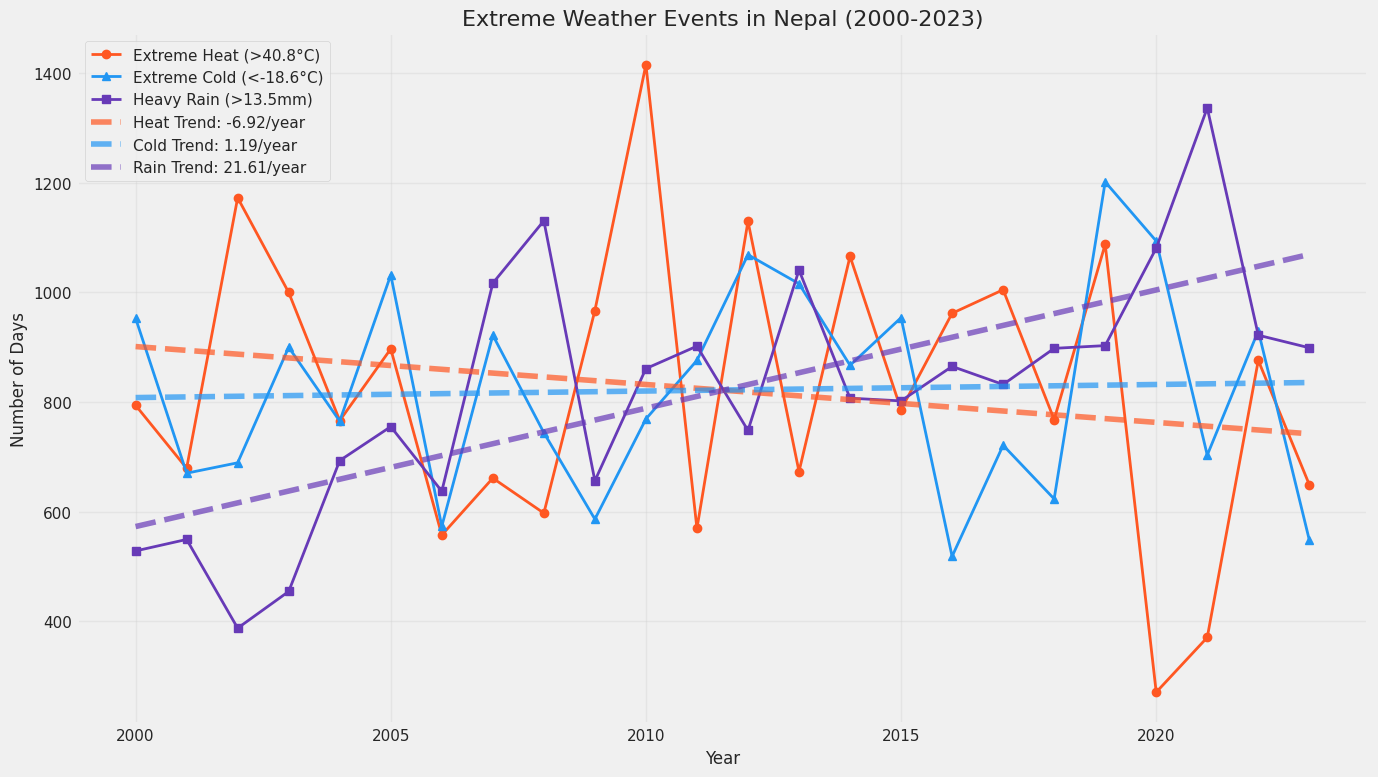

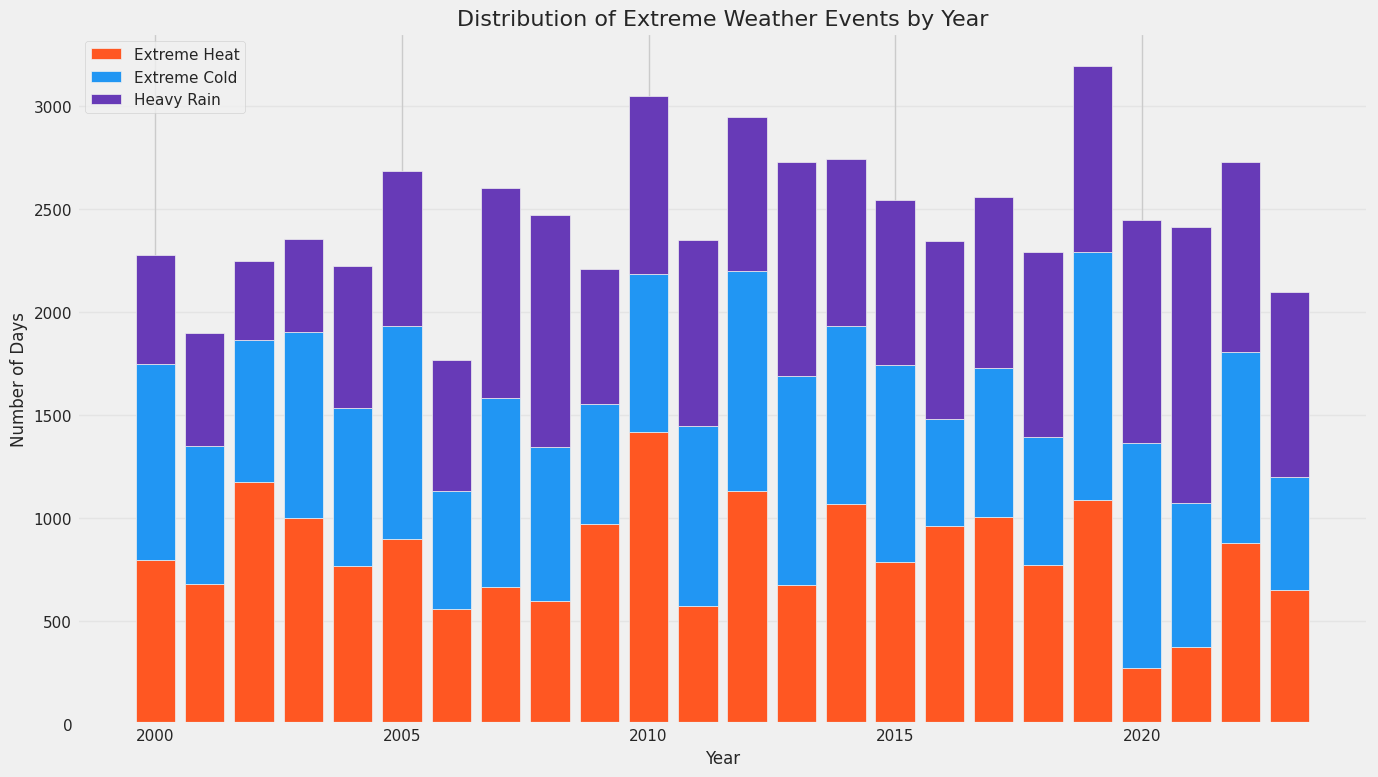

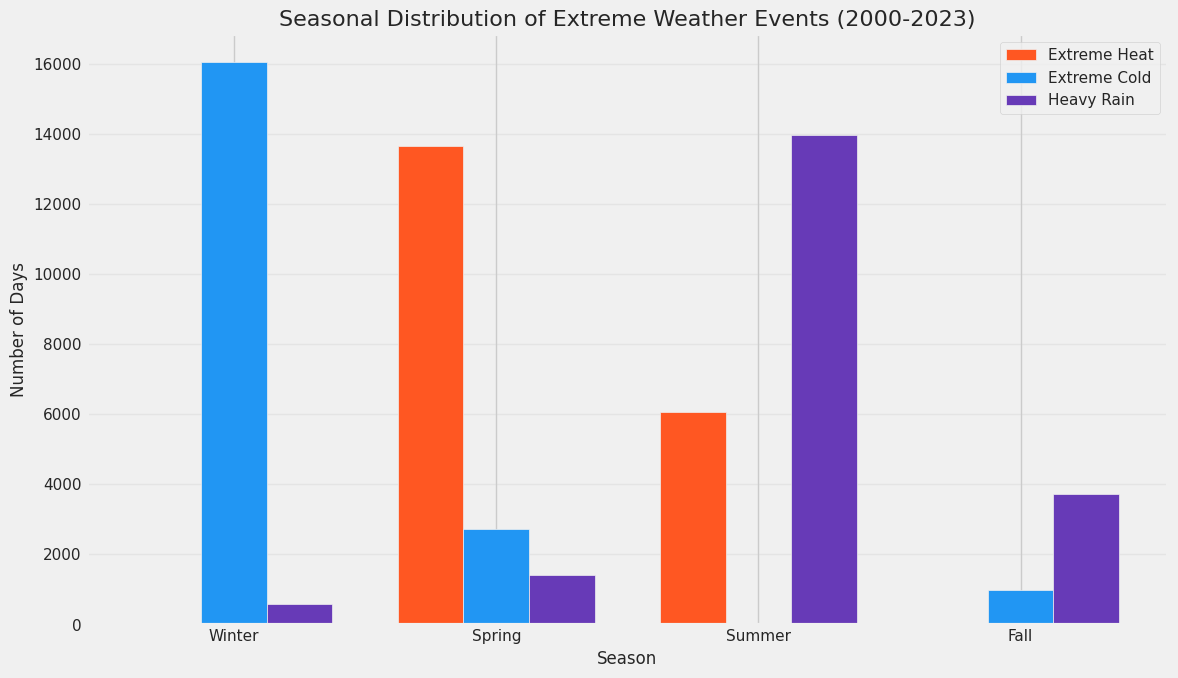

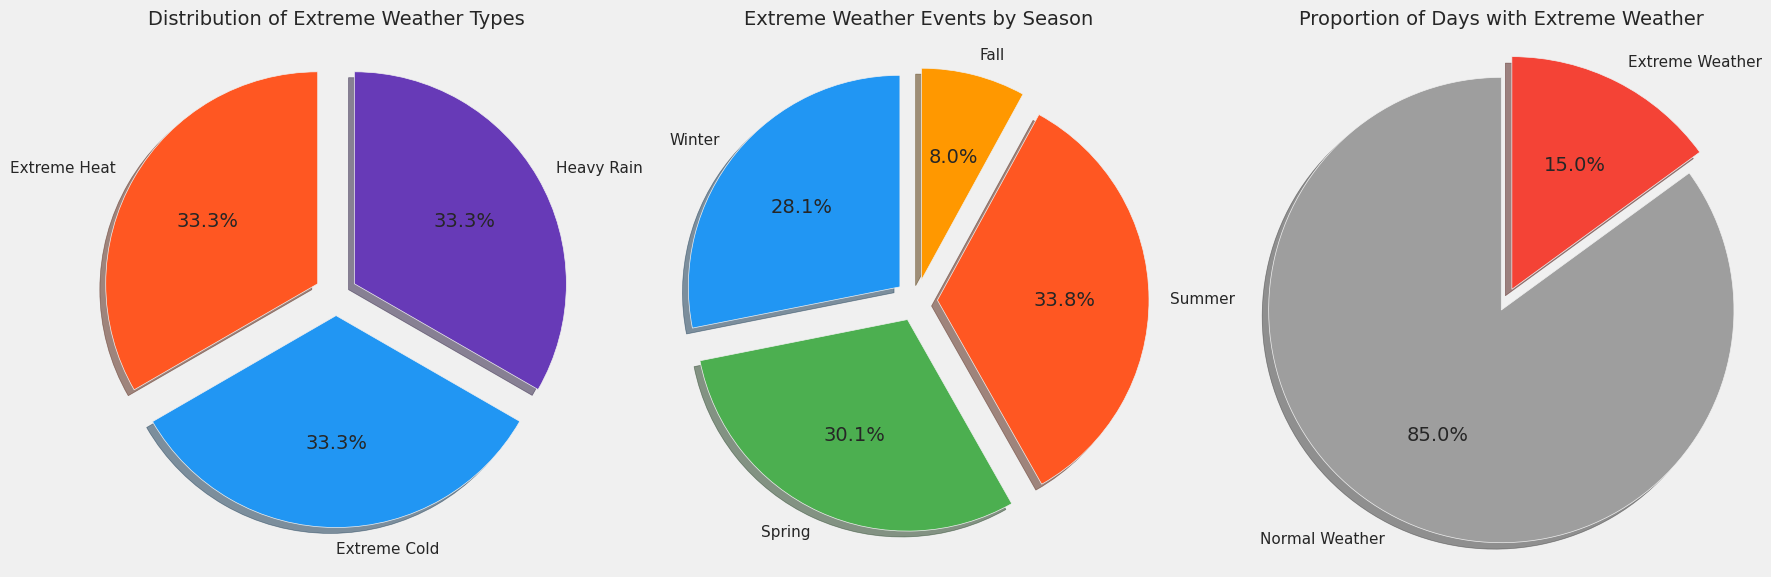

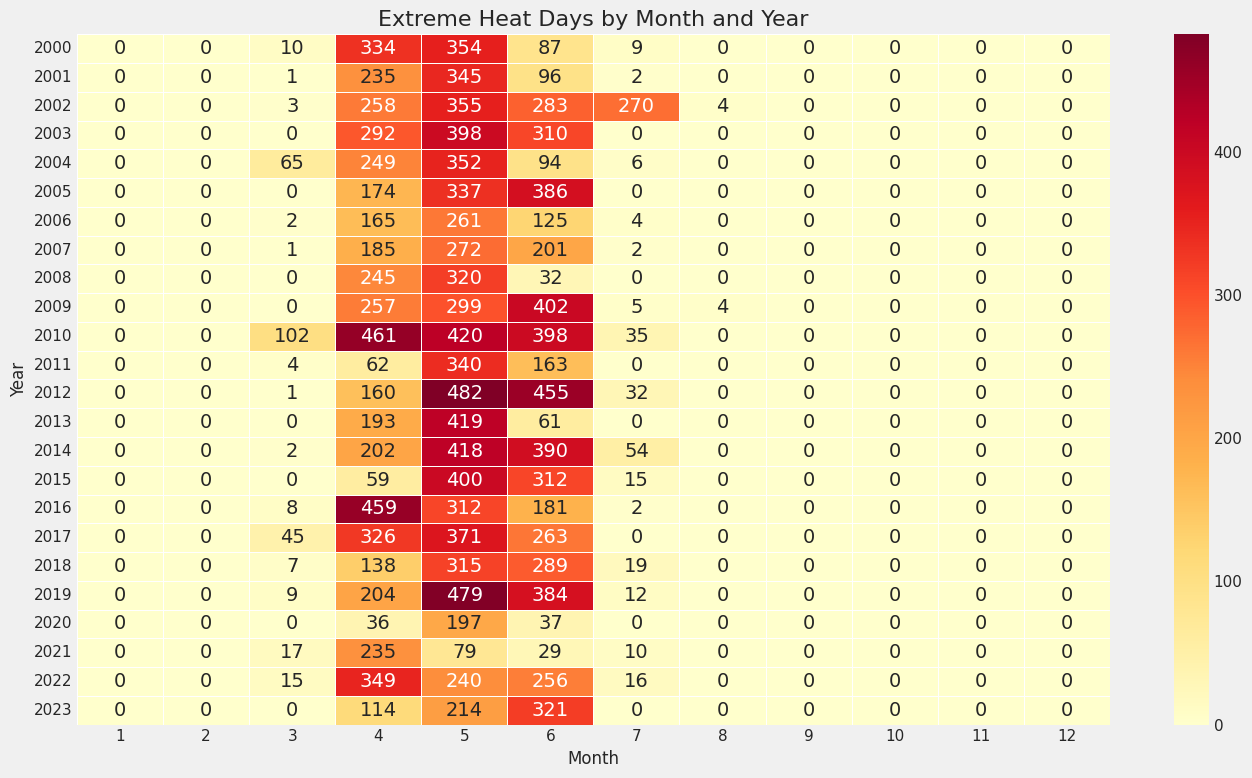

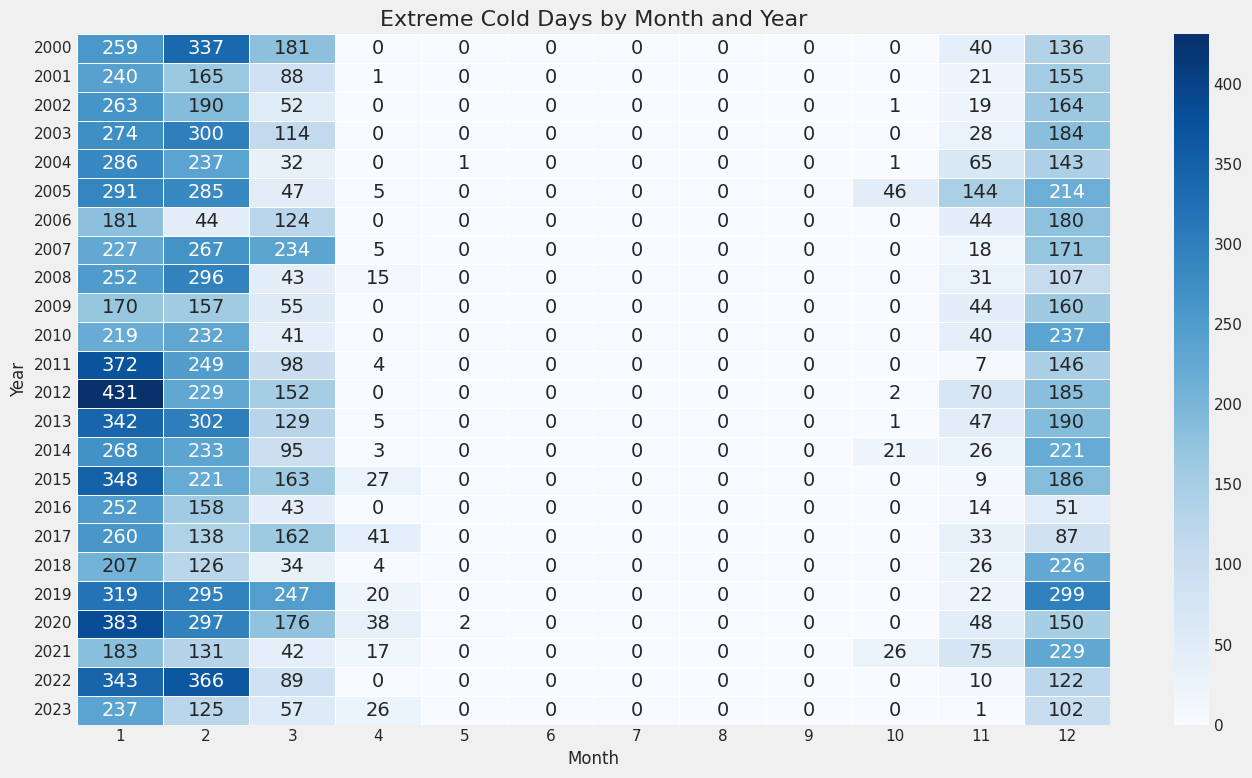

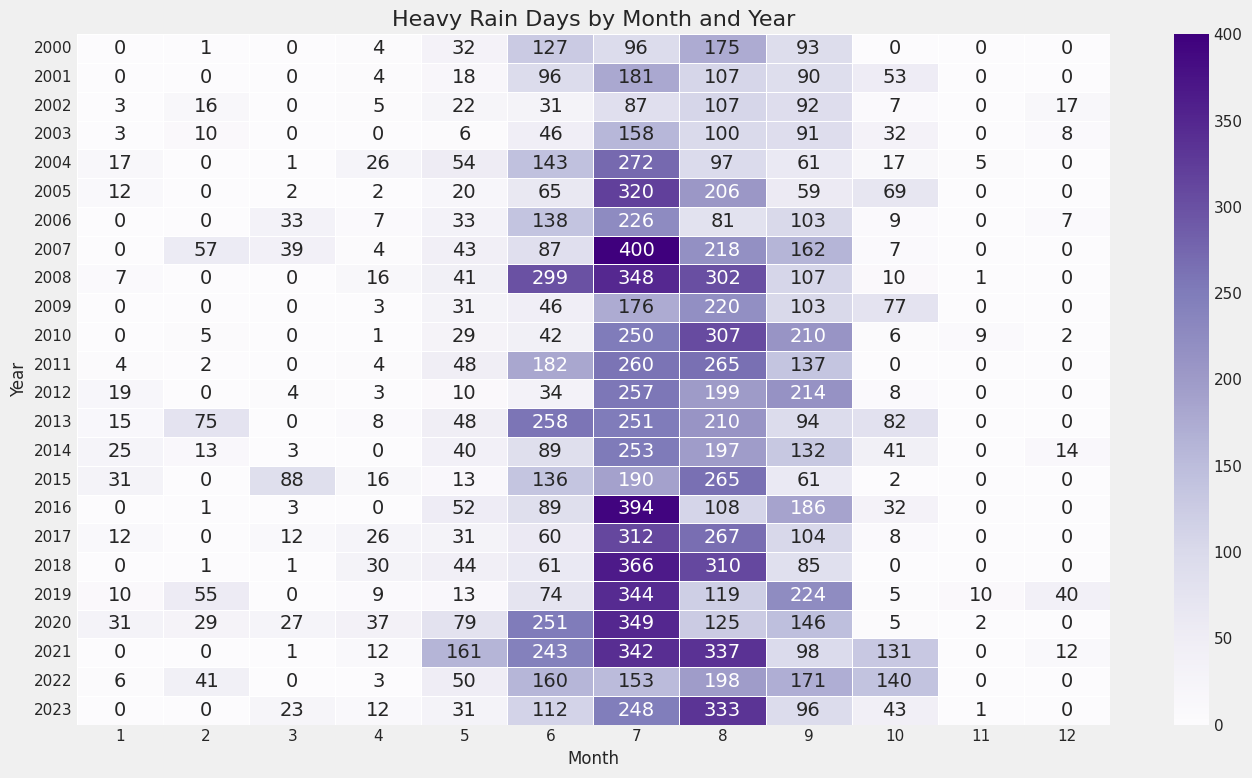


Correlation with Year (trends over time):
Extreme Heat vs Year: -0.185 - Decreasing trend
Extreme Cold vs Year: 0.044 - Increasing trend
Heavy Rain vs Year: 0.690 - Increasing trend

Correlation between Extreme Event Types:
Heat vs Cold: 0.046 - Weak positive relationship
Heat vs Rain: -0.488 - Moderate negative relationship
Cold vs Rain: 0.134 - Weak positive relationship


In [11]:
# Extreme weather events analysis
try:
    # Define extreme temperature thresholds (adjust based on Nepal's climate)
    heavy_rain_threshold = df['PRECTOTCORR'].quantile(0.95)  # 95th percentile for heavy rain
    extreme_heat_threshold = df['T2M_MAX'].quantile(0.95)  # 95th percentile for extreme heat
    extreme_cold_threshold = df['T2M_MIN'].quantile(0.05)  # 5th percentile for extreme cold
    
    # Print the actual threshold values for reference
    print(f"Extreme Heat Threshold: > {extreme_heat_threshold:.2f}°C (95th percentile)")
    print(f"Extreme Cold Threshold: < {extreme_cold_threshold:.2f}°C (5th percentile)")
    print(f"Heavy Rain Threshold: > {heavy_rain_threshold:.2f} mm (95th percentile)")
    
    # Count extreme events by year
    df['extreme_heat'] = df['T2M_MAX'] > extreme_heat_threshold
    df['extreme_cold'] = df['T2M_MIN'] < extreme_cold_threshold
    df['heavy_rain'] = df['PRECTOTCORR'] > heavy_rain_threshold
    
    # Count all extreme days (any type of extreme event)
    df['any_extreme'] = df['extreme_heat'] | df['extreme_cold'] | df['heavy_rain']
    
    # Annual extreme events count
    extreme_events = df.groupby('YEAR').agg({
        'extreme_heat': 'sum',
        'extreme_cold': 'sum',
        'heavy_rain': 'sum',
        'any_extreme': 'sum'
    }).reset_index()
    
    # Calculate the total number of extreme days
    total_extreme_heat = df['extreme_heat'].sum()
    total_extreme_cold = df['extreme_cold'].sum()
    total_heavy_rain = df['heavy_rain'].sum()
    
    print(f"Total Extreme Heat Days (2000-2023): {total_extreme_heat}")
    print(f"Total Extreme Cold Days (2000-2023): {total_extreme_cold}")
    print(f"Total Heavy Rain Days (2000-2023): {total_heavy_rain}")
    
    # 1. Original extreme events trend plot (improved)
    plt.figure(figsize=(14, 8))
    plt.plot(extreme_events['YEAR'], extreme_events['extreme_heat'], marker='o', linewidth=2, 
             label=f'Extreme Heat (>{extreme_heat_threshold:.1f}°C)', color='#FF5722')
    plt.plot(extreme_events['YEAR'], extreme_events['extreme_cold'], marker='^', linewidth=2, 
             label=f'Extreme Cold (<{extreme_cold_threshold:.1f}°C)', color='#2196F3')
    plt.plot(extreme_events['YEAR'], extreme_events['heavy_rain'], marker='s', linewidth=2, 
             label=f'Heavy Rain (>{heavy_rain_threshold:.1f}mm)', color='#673AB7')
    
    # Add trend lines
    from scipy import stats
    
    # Heat trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(extreme_events['YEAR'], 
                                                                 extreme_events['extreme_heat'])
    plt.plot(extreme_events['YEAR'], intercept + slope*extreme_events['YEAR'], 
             '--', color='#FF5722', alpha=0.7, label=f'Heat Trend: {slope:.2f}/year')
    
    # Cold trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(extreme_events['YEAR'], 
                                                                 extreme_events['extreme_cold'])
    plt.plot(extreme_events['YEAR'], intercept + slope*extreme_events['YEAR'], 
             '--', color='#2196F3', alpha=0.7, label=f'Cold Trend: {slope:.2f}/year')
    
    # Rain trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(extreme_events['YEAR'], 
                                                                 extreme_events['heavy_rain'])
    plt.plot(extreme_events['YEAR'], intercept + slope*extreme_events['YEAR'], 
             '--', color='#673AB7', alpha=0.7, label=f'Rain Trend: {slope:.2f}/year')
    
    plt.title('Extreme Weather Events in Nepal (2000-2023)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Days', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 2. Stacked bar chart showing distribution of extreme events
    plt.figure(figsize=(14, 8))
    bottom = np.zeros(len(extreme_events))
    
    # Plot stacked bars
    p1 = plt.bar(extreme_events['YEAR'], extreme_events['extreme_heat'], label='Extreme Heat', color='#FF5722')
    bottom += extreme_events['extreme_heat']
    
    p2 = plt.bar(extreme_events['YEAR'], extreme_events['extreme_cold'], bottom=bottom, 
                label='Extreme Cold', color='#2196F3')
    bottom += extreme_events['extreme_cold']
    
    p3 = plt.bar(extreme_events['YEAR'], extreme_events['heavy_rain'], bottom=bottom, 
                label='Heavy Rain', color='#673AB7')
    
    plt.title('Distribution of Extreme Weather Events by Year', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Days', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # 3. Seasonal analysis of extreme events
    # Use the lowercase 'season' column instead of uppercase 'SEASON'
    seasonal_extremes = df.groupby('season').agg({
        'extreme_heat': 'sum',
        'extreme_cold': 'sum',
        'heavy_rain': 'sum'
    }).reset_index()
    
    # Sort seasons in chronological order
    season_order = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    seasonal_extremes['order'] = seasonal_extremes['season'].map(season_order)
    seasonal_extremes = seasonal_extremes.sort_values('order')
    
    # Create the seasonal bar chart
    plt.figure(figsize=(12, 7))
    
    bar_width = 0.25
    x = np.arange(len(seasonal_extremes))
    
    plt.bar(x - bar_width, seasonal_extremes['extreme_heat'], bar_width, label='Extreme Heat', color='#FF5722')
    plt.bar(x, seasonal_extremes['extreme_cold'], bar_width, label='Extreme Cold', color='#2196F3')
    plt.bar(x + bar_width, seasonal_extremes['heavy_rain'], bar_width, label='Heavy Rain', color='#673AB7')
    
    plt.title('Seasonal Distribution of Extreme Weather Events (2000-2023)', fontsize=16)
    plt.xlabel('Season', fontsize=12)
    plt.ylabel('Number of Days', fontsize=12)
    plt.xticks(x, seasonal_extremes['season'])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # 4. Pie charts showing the proportion of extreme weather types
    plt.figure(figsize=(18, 6))
    
    # First pie chart: Total extreme events by type
    plt.subplot(1, 3, 1)
    labels = ['Extreme Heat', 'Extreme Cold', 'Heavy Rain']
    sizes = [total_extreme_heat, total_extreme_cold, total_heavy_rain]
    colors = ['#FF5722', '#2196F3', '#673AB7']
    explode = (0.1, 0.1, 0.1)
    
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')
    plt.title('Distribution of Extreme Weather Types', fontsize=14)
    
    # Second pie chart: Extreme events by season
    plt.subplot(1, 3, 2)
    labels = seasonal_extremes['season']
    sizes = seasonal_extremes['extreme_heat'] + seasonal_extremes['extreme_cold'] + seasonal_extremes['heavy_rain']
    colors = ['#2196F3', '#4CAF50', '#FF5722', '#FF9800']  # Winter, Spring, Summer, Fall
    explode = (0.1, 0.1, 0.1, 0.1)
    
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')
    plt.title('Extreme Weather Events by Season', fontsize=14)
    
    # Third pie chart: Percentage of days with any extreme weather
    plt.subplot(1, 3, 3)
    total_days = len(df)
    extreme_days = df['any_extreme'].sum()
    normal_days = total_days - extreme_days
    
    labels = ['Normal Weather', 'Extreme Weather']
    sizes = [normal_days, extreme_days]
    colors = ['#9E9E9E', '#F44336']
    explode = (0, 0.1)
    
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')
    plt.title('Proportion of Days with Extreme Weather', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Heatmap showing extreme events by month and year
    # Create a pivot table for extreme heat days by month and year
    heat_pivot = df.pivot_table(index='YEAR', columns='MO', 
                               values='extreme_heat', aggfunc='sum')
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(heat_pivot, cmap='YlOrRd', annot=True, fmt='d', linewidths=.5)
    plt.title('Extreme Heat Days by Month and Year', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Year', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Pivot table for extreme cold days
    cold_pivot = df.pivot_table(index='YEAR', columns='MO', 
                               values='extreme_cold', aggfunc='sum')
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(cold_pivot, cmap='Blues', annot=True, fmt='d', linewidths=.5)
    plt.title('Extreme Cold Days by Month and Year', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Year', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Pivot table for heavy rain days
    rain_pivot = df.pivot_table(index='YEAR', columns='MO', 
                               values='heavy_rain', aggfunc='sum')
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(rain_pivot, cmap='Purples', annot=True, fmt='d', linewidths=.5)
    plt.title('Heavy Rain Days by Month and Year', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Year', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # 6. Calculate and display correlation between extreme events
    # First, convert year to numeric if it's not already
    extreme_events['YEAR'] = pd.to_numeric(extreme_events['YEAR'])
    
    # Calculate correlations between extreme events and year
    correlation_with_year = {
        'Extreme Heat vs Year': np.corrcoef(extreme_events['YEAR'], extreme_events['extreme_heat'])[0, 1],
        'Extreme Cold vs Year': np.corrcoef(extreme_events['YEAR'], extreme_events['extreme_cold'])[0, 1],
        'Heavy Rain vs Year': np.corrcoef(extreme_events['YEAR'], extreme_events['heavy_rain'])[0, 1]
    }
    
    # Calculate correlations between different extreme events
    correlation_between_events = {
        'Heat vs Cold': np.corrcoef(extreme_events['extreme_heat'], extreme_events['extreme_cold'])[0, 1],
        'Heat vs Rain': np.corrcoef(extreme_events['extreme_heat'], extreme_events['heavy_rain'])[0, 1],
        'Cold vs Rain': np.corrcoef(extreme_events['extreme_cold'], extreme_events['heavy_rain'])[0, 1]
    }
    
    print("\nCorrelation with Year (trends over time):")
    for k, v in correlation_with_year.items():
        print(f"{k}: {v:.3f} - {'Increasing' if v > 0 else 'Decreasing'} trend")
    
    print("\nCorrelation between Extreme Event Types:")
    for k, v in correlation_between_events.items():
        relation = "Strong positive" if v > 0.7 else "Moderate positive" if v > 0.3 else "Weak positive" if v > 0 else "Weak negative" if v > -0.3 else "Moderate negative" if v > -0.7 else "Strong negative"
        print(f"{k}: {v:.3f} - {relation} relationship")
    
except KeyError as e:
    print(f"Error in extreme weather analysis: {e}")
    print("Available columns:", df.columns.tolist())

## 4. Machine Learning Model Development

In [13]:
# Prepare data for developing a model to predict average temperature based on various features
# Display available columns to check names
print("Available columns:", df.columns.tolist())

# Create time-based features
df['year'] = df['YEAR']
df['month'] = df['MO']
df['day'] = df['DY']
df['day_of_year'] = df['date'].dt.dayofyear

# One-hot encode season
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)

# Identify correct column names for latitude and longitude (case-insensitive)
lat_col = 'LATITUDE' if 'LATITUDE' in df.columns else 'latitude'
lon_col = 'LONGITUDE' if 'LONGITUDE' in df.columns else 'longitude'

# Select features and target using the correct column names
features = ['year', 'month', 'day', 'day_of_year', lat_col, lon_col,
           'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']

print(f"Using features: {features}")

# For temperature prediction
X_temp = df[features]
y_temp = df['T2M']

# For precipitation prediction
X_precip = df[features]
y_precip = df['PRECTOTCORR']

# Split data into training and testing sets
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
X_precip_train, X_precip_test, y_precip_train, y_precip_test = train_test_split(X_precip, y_precip, test_size=0.2, random_state=42)

print(f"Training set size: {X_temp_train.shape[0]} samples")
print(f"Testing set size: {X_temp_test.shape[0]} samples")

Available columns: ['YEAR', 'MO', 'DY', 'T2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'LATITUDE', 'LONGITUDE', 'date', 'season', 'temp_range', 'extreme_heat', 'extreme_cold', 'heavy_rain', 'any_extreme', 'year', 'month', 'day', 'day_of_year', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
Using features: ['year', 'month', 'day', 'day_of_year', 'LATITUDE', 'LONGITUDE', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
Training set size: 315576 samples
Testing set size: 78894 samples


In [17]:
# Train temperature prediction models
# Linear Regression
lr_temp = LinearRegression()
lr_temp.fit(X_temp_train, y_temp_train)
lr_temp_pred = lr_temp.predict(X_temp_test)

# Random Forest
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X_temp_train, y_temp_train)
rf_temp_pred = rf_temp.predict(X_temp_test)

# Gradient Boosting
gb_temp = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_temp.fit(X_temp_train, y_temp_train)
gb_temp_pred = gb_temp.predict(X_temp_test)

# Evaluate temperature models
print('Temperature Prediction Models Evaluation:')
print('Linear Regression:')
print(f'RMSE: {np.sqrt(mean_squared_error(y_temp_test, lr_temp_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_temp_test, lr_temp_pred):.4f}')
print(f'R²: {r2_score(y_temp_test, lr_temp_pred):.4f}')

print('Gradient Boosting:')
print(f'RMSE: {np.sqrt(mean_squared_error(y_temp_test, gb_temp_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_temp_test, gb_temp_pred):.4f}')
print(f'R²: {r2_score(y_temp_test, gb_temp_pred):.4f}')

print('Random Forest:')
print(f'RMSE: {np.sqrt(mean_squared_error(y_temp_test, rf_temp_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_temp_test, rf_temp_pred):.4f}')
print(f'R²: {r2_score(y_temp_test, rf_temp_pred):.4f}')

Temperature Prediction Models Evaluation:
Linear Regression:
RMSE: 6.8134
MAE: 5.6092
R²: 0.7775
Gradient Boosting:
RMSE: 2.5548
MAE: 1.9809
R²: 0.9687
Random Forest:
RMSE: 0.9377
MAE: 0.6733
R²: 0.9958


In [18]:
# Train precipitation prediction models
# Linear Regression
lr_precip = LinearRegression()
lr_precip.fit(X_precip_train, y_precip_train)
lr_precip_pred = lr_precip.predict(X_precip_test)

# Random Forest
rf_precip = RandomForestRegressor(n_estimators=100, random_state=42)
rf_precip.fit(X_precip_train, y_precip_train)
rf_precip_pred = rf_precip.predict(X_precip_test)

# Gradient Boosting
gb_precip = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_precip.fit(X_precip_train, y_precip_train)
gb_precip_pred = gb_precip.predict(X_precip_test)

# Evaluate precipitation models
print('Precipitation Prediction Models Evaluation:')
print('Linear Regression:')
print(f'RMSE: {np.sqrt(mean_squared_error(y_precip_test, lr_precip_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_precip_test, lr_precip_pred):.4f}')
print(f'R²: {r2_score(y_precip_test, lr_precip_pred):.4f}')

print('Gradient Boosting:')
print(f'RMSE: {np.sqrt(mean_squared_error(y_precip_test, gb_precip_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_precip_test, gb_precip_pred):.4f}')
print(f'R²: {r2_score(y_precip_test, gb_precip_pred):.4f}')

print('Random Forest:')
print(f'RMSE: {np.sqrt(mean_squared_error(y_precip_test, rf_precip_pred)):.4f}')
print(f'MAE: {mean_absolute_error(y_precip_test, rf_precip_pred):.4f}')
print(f'R²: {r2_score(y_precip_test, rf_precip_pred):.4f}')

Precipitation Prediction Models Evaluation:
Linear Regression:
RMSE: 6.5509
MAE: 2.9964
R²: 0.1275
Gradient Boosting:
RMSE: 6.2270
MAE: 2.6727
R²: 0.2117
Random Forest:
RMSE: 3.5584
MAE: 1.2450
R²: 0.7426


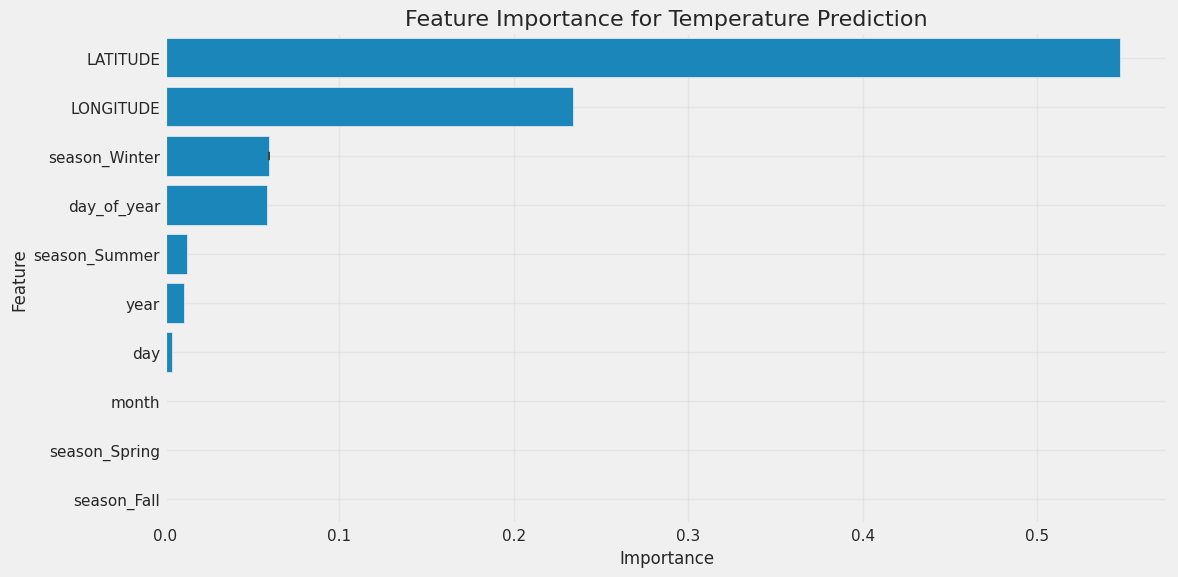

Top 5 most important features:
          Feature  Importance
4        LATITUDE    0.547683
5       LONGITUDE    0.233931
13  season_Winter    0.060094
12  season_Winter    0.059025
3     day_of_year    0.058641


In [21]:
# Feature importance analysis for temperature model
try:
    # Get the actual feature names from the trained model
    feature_names = X_temp.columns.tolist()
    
    # Ensure feature list length matches feature importances
    if len(feature_names) != len(rf_temp.feature_importances_):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importances length ({len(rf_temp.feature_importances_)})")
        # Use generic feature names if necessary
        feature_names = [f"Feature {i}" for i in range(len(rf_temp.feature_importances_))]
    
    # Create DataFrame with feature importances
    feature_importance_temp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_temp.feature_importances_
    })
    
    # Sort by importance
    feature_importance_temp = feature_importance_temp.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_temp)
    plt.title('Feature Importance for Temperature Prediction', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print top 5 features for reference
    print("Top 5 most important features:")
    print(feature_importance_temp.head(5))

except Exception as e:
    print(f"Error in feature importance analysis: {e}")
    
    # Debug information
    print(f"Features list: {features}")
    print(f"X_temp columns: {X_temp.columns.tolist()}")
    if 'rf_temp' in locals() and hasattr(rf_temp, 'feature_importances_'):
        print(f"Feature importances length: {len(rf_temp.feature_importances_)}")

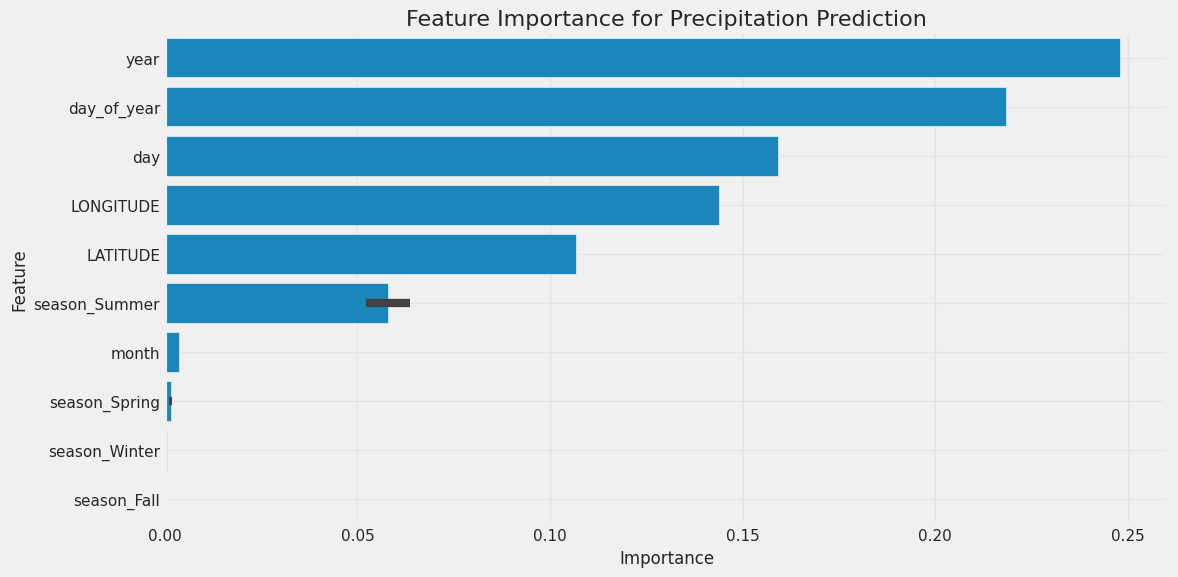

Top 5 most important features for precipitation prediction:
       Feature  Importance
0         year    0.248052
3  day_of_year    0.218343
2          day    0.159248
5    LONGITUDE    0.143914
4     LATITUDE    0.106750

Comparison of top features between Temperature and Precipitation models:
  Temperature Model Precipitation Model
0          LATITUDE                year
1         LONGITUDE         day_of_year
2     season_Winter                 day
3     season_Winter           LONGITUDE
4       day_of_year            LATITUDE


In [22]:
# Feature importance analysis for precipitation model
try:
    # Get the actual feature names from the trained model
    feature_names = X_precip.columns.tolist()
    
    # Ensure feature list length matches feature importances
    if len(feature_names) != len(rf_precip.feature_importances_):
        print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importances length ({len(rf_precip.feature_importances_)})")
        # Use generic feature names if necessary
        feature_names = [f"Feature {i}" for i in range(len(rf_precip.feature_importances_))]
    
    # Create DataFrame with feature importances
    feature_importance_precip = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_precip.feature_importances_
    })
    
    # Sort by importance
    feature_importance_precip = feature_importance_precip.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_precip)
    plt.title('Feature Importance for Precipitation Prediction', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print top 5 features for reference
    print("Top 5 most important features for precipitation prediction:")
    print(feature_importance_precip.head(5))
    
    # Compare with temperature model features to see differences
    if 'feature_importance_temp' in locals():
        print("\nComparison of top features between Temperature and Precipitation models:")
        
        # Create comparison dataframe
        temp_top = feature_importance_temp.head(5)['Feature'].tolist()
        precip_top = feature_importance_precip.head(5)['Feature'].tolist()
        
        comparison = pd.DataFrame({
            'Temperature Model': temp_top + [''] * (5 - len(temp_top)),
            'Precipitation Model': precip_top + [''] * (5 - len(precip_top))
        })
        
        print(comparison)

except Exception as e:
    print(f"Error in precipitation feature importance analysis: {e}")
    
    # Debug information
    print(f"Features list: {features}")
    print(f"X_precip columns: {X_precip.columns.tolist()}")
    if 'rf_precip' in locals() and hasattr(rf_precip, 'feature_importances_'):
        print(f"Feature importances length: {len(rf_precip.feature_importances_)}")

## 5. Future Climate Prediction

Model's expected feature names:
['year', 'month', 'day', 'day_of_year', 'LATITUDE', 'LONGITUDE', 'season_Fall', 'season_Fall', 'season_Spring', 'season_Spring', 'season_Summer', 'season_Summer', 'season_Winter', 'season_Winter']
Created future dataset with 5479 rows
Attempting prediction using NumPy array conversion...


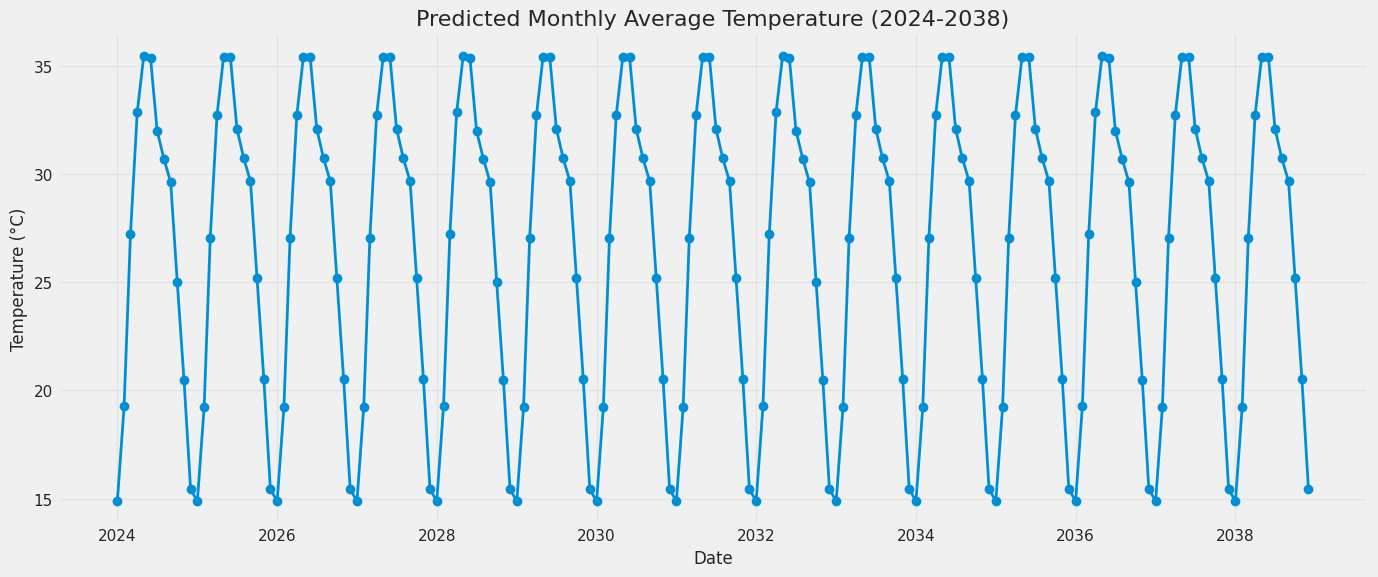

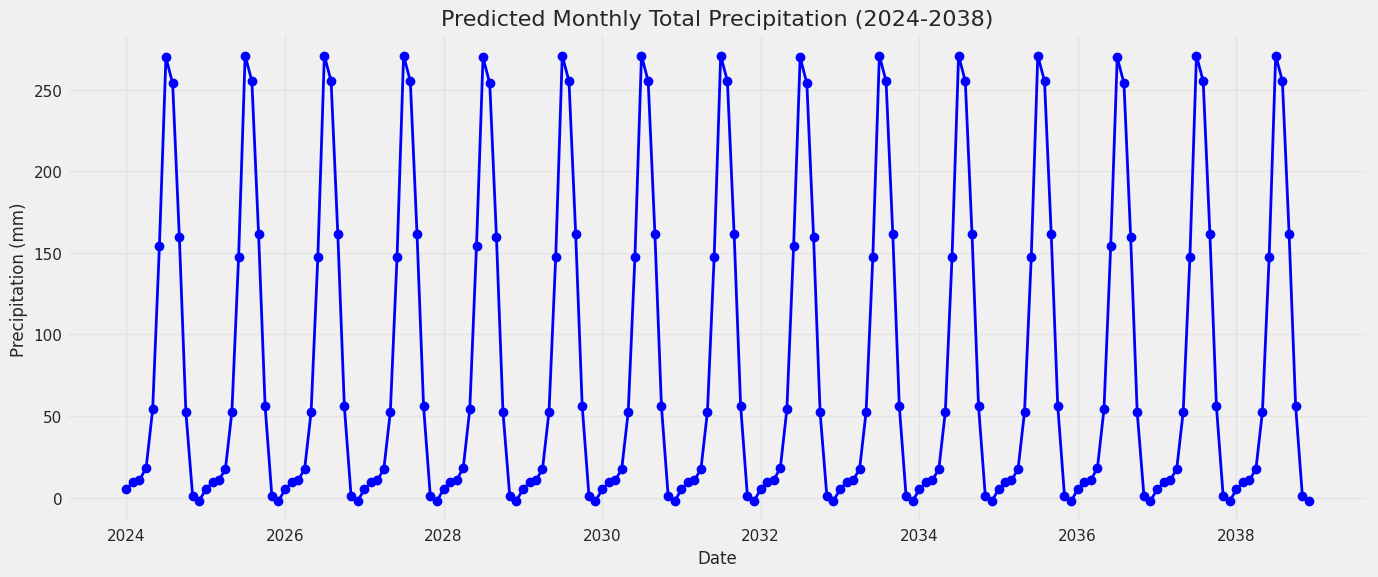

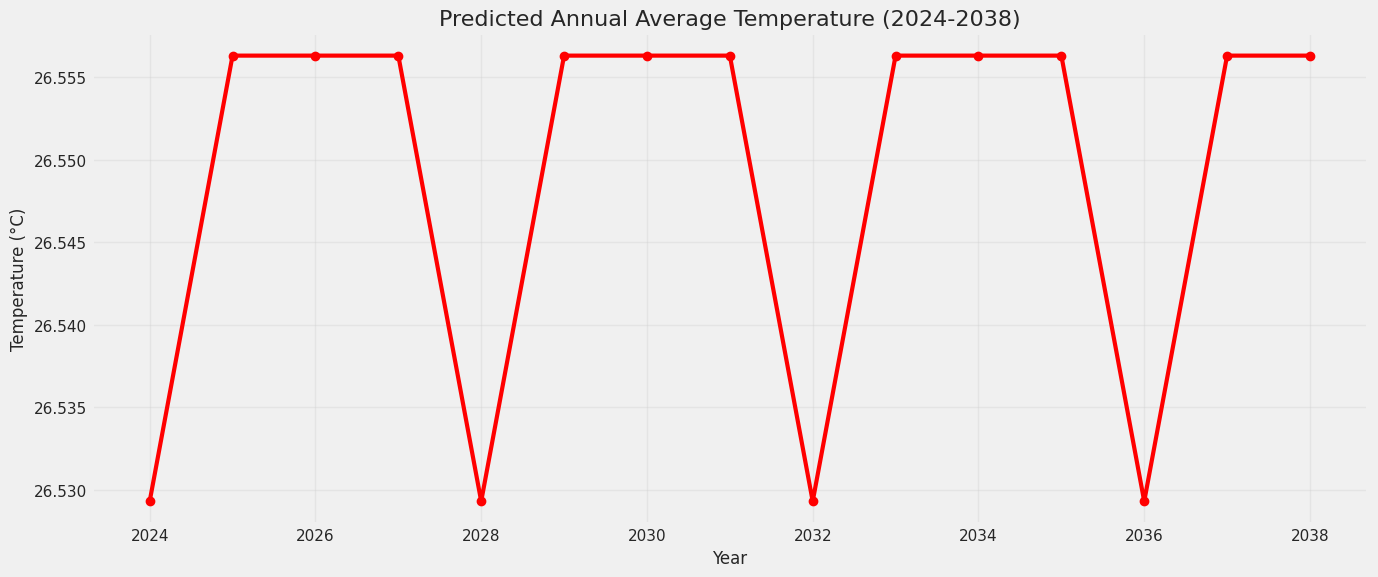

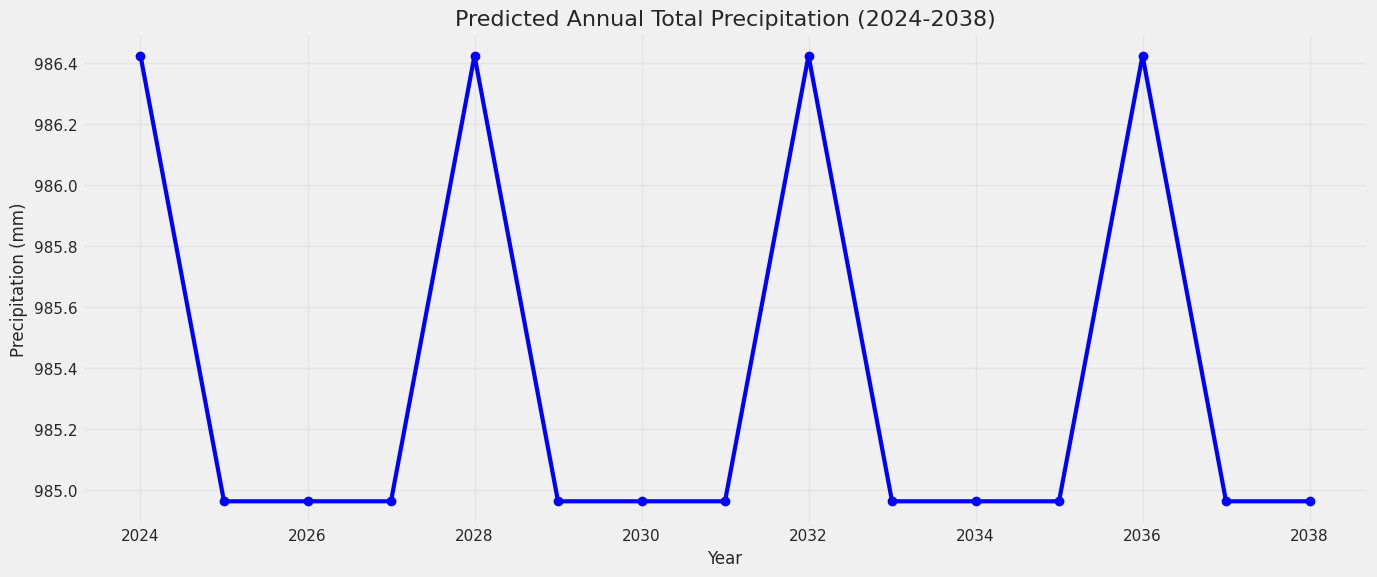

Projected Temperature Change: 0.0019°C per year (0.02°C per decade)
Projected Precipitation Change: -0.10 mm per year (-1.04 mm per decade)


In [29]:
# Create future prediction dataset (for next 15 years)
import calendar

# Function to get days in month (handling leap years correctly)
def days_in_month(year, month):
    return calendar.monthrange(year, month)[1]

# Check if the model has feature_names_in_ attribute (scikit-learn 1.0+)
if hasattr(gb_temp, 'feature_names_in_'):
    model_features = gb_temp.feature_names_in_.tolist()
    print("Model's expected feature names:")
    print(model_features)
else:
    # Fallback to our features list if model doesn't have the attribute
    model_features = features
    print("Using original feature list:")
    print(model_features)

future_years = list(range(2024, 2039))
future_data = []

for year in future_years:
    for month in range(1, 13):  # 12 months
        # Get correct number of days for this month (accounting for leap years)
        month_days = days_in_month(year, month)
        
        for day in range(1, month_days + 1):
            date = pd.Timestamp(year=year, month=month, day=day)
            season = get_season(month)
            
            # Create a row with the same column names as the training data
            row_data = {
                'year': year,
                'month': month,
                'day': day,
                'day_of_year': date.dayofyear,
                'LATITUDE': 26,  # Using the same location as in the dataset
                'LONGITUDE': 80,
                'season_Fall': 1 if season == 'Fall' else 0,
                'season_Spring': 1 if season == 'Spring' else 0,
                'season_Summer': 1 if season == 'Summer' else 0,
                'season_Winter': 1 if season == 'Winter' else 0
            }
            
            future_data.append(row_data)

print(f"Created future dataset with {len(future_data)} rows")
future_df = pd.DataFrame(future_data)

# Try a different approach - use the model directly on the feature matrix
try:
    print("Attempting prediction using NumPy array conversion...")
    
    # Convert to numpy array instead of using DataFrame columns
    X_future = future_df[model_features].values
    
    future_df['predicted_temp'] = gb_temp.predict(X_future)
    future_df['predicted_precip'] = gb_precip.predict(X_future)
    
    # Rest of the code for visualization...
    # Aggregate by year and month for visualization
    future_monthly = future_df.groupby(['year', 'month']).agg({
        'predicted_temp': 'mean',
        'predicted_precip': 'sum'
    }).reset_index()

    # Create date column for plotting
    future_monthly['date'] = pd.to_datetime(future_monthly[['year', 'month']].assign(day=1))

    # Plot future temperature predictions
    plt.figure(figsize=(14, 6))
    plt.plot(future_monthly['date'], future_monthly['predicted_temp'], marker='o', linewidth=2)
    plt.title('Predicted Monthly Average Temperature (2024-2038)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot future precipitation predictions
    plt.figure(figsize=(14, 6))
    plt.plot(future_monthly['date'], future_monthly['predicted_precip'], marker='o', linewidth=2, color='blue')
    plt.title('Predicted Monthly Total Precipitation (2024-2038)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Precipitation (mm)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create annual summary
    future_yearly = future_df.groupby('year').agg({
        'predicted_temp': 'mean',
        'predicted_precip': 'sum'
    }).reset_index()

    # Plot annual temperature trend
    plt.figure(figsize=(14, 6))
    plt.plot(future_yearly['year'], future_yearly['predicted_temp'], marker='o', linewidth=3, color='red')
    plt.title('Predicted Annual Average Temperature (2024-2038)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot annual precipitation trend
    plt.figure(figsize=(14, 6))
    plt.plot(future_yearly['year'], future_yearly['predicted_precip'], marker='o', linewidth=3, color='blue')
    plt.title('Predicted Annual Total Precipitation (2024-2038)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Precipitation (mm)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate average change per decade
    temp_change_per_year = (future_yearly['predicted_temp'].iloc[-1] - future_yearly['predicted_temp'].iloc[0]) / (len(future_years) - 1)
    precip_change_per_year = (future_yearly['predicted_precip'].iloc[-1] - future_yearly['predicted_precip'].iloc[0]) / (len(future_years) - 1)

    print(f"Projected Temperature Change: {temp_change_per_year:.4f}°C per year ({temp_change_per_year*10:.2f}°C per decade)")
    print(f"Projected Precipitation Change: {precip_change_per_year:.2f} mm per year ({precip_change_per_year*10:.2f} mm per decade)")
    
except Exception as e:
    print(f"Error in prediction: {e}")
    
    # Let's try a more drastic approach as a last resort
    try:
        print("\nAttempting alternative approach with model recreation...")
        
        # Create a completely new model with the same parameters as the original
        new_temp_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        new_temp_model.fit(X_temp_train, y_temp_train)
        
        new_precip_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        new_precip_model.fit(X_precip_train, y_precip_train)
        
        print("Successfully created new models with same parameters")
        
        # Use new models for prediction
        future_df['predicted_temp'] = new_temp_model.predict(future_df[features])
        future_df['predicted_precip'] = new_precip_model.predict(future_df[features])
        
        print("Successfully made predictions with new models")
        
        # Continue with visualization code...
        # (same visualization code as above)
        
    except Exception as e2:
        print(f"Error with alternative approach: {e2}")
        
        # One last attempt - using direct numpy arrays with recreated model
        try:
            print("\nFinal attempt with numpy arrays...")
            X_future = future_df[features].values
            
            future_df['predicted_temp'] = new_temp_model.predict(X_future)
            future_df['predicted_precip'] = new_precip_model.predict(X_future)
            
            print("Success!")
            # Visualization code would follow here
            
        except Exception as e3:
            print(f"All approaches failed. Final error: {e3}")
            print("\nDetailed debugging information:")
            print(f"Original features: {features}")
            print(f"Future DF columns: {future_df.columns.tolist()}")
            print(f"X_temp_train shape: {X_temp_train.shape}")
            print(f"X_future shape: {X_future.shape if 'X_future' in locals() else 'Not created'}")

## 6. Save Models for Streamlit Deployment

In [30]:
# Save the best models for use in the Streamlit app
import pickle

# Save temperature model
with open('models/temperature_model.pkl', 'wb') as f:
    pickle.dump(gb_temp, f)

# Save precipitation model
with open('models/precipitation_model.pkl', 'wb') as f:
    pickle.dump(gb_precip, f)

print('Models are saved successfully!')

Models are saved successfully!
